In [32]:
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
## Function that accepts a CSV file path as an argument and returns a dataframe.
## Dataframe has a 'timestamp' column and 'metric_value' column that corresponds to http_req_duration
def create_timeseries_df(csv_file_path):
    """
    Creates a timeseries dataframe from a csv path. 

    Args:
     * csv_file_path - string path. 

    Returns:
     * Pandas DF
    
    """
    timeseries_df = pd.read_csv(csv_file_path)
    timeseries_df = timeseries_df[['metric_name', 'timestamp', 'metric_value']]
    timeseries_df = timeseries_df[timeseries_df['metric_name'] == 'http_req_duration'][['timestamp', 'metric_value']]
    timeseries_df = timeseries_df.groupby(timeseries_df['timestamp']).median()
    timeseries_df = timeseries_df.reset_index()
    return timeseries_df

In [45]:
express_timeseries_df = create_timeseries_df('./csv/express_app_timeseries.csv')
fastapi_timeseries_df = create_timeseries_df('./csv/fastapi_app_timeseries.csv')

express_stress_test_timeseries_df = create_timeseries_df('./csv/express_app_stress_test_timeseries.csv')
fastapi_stress_test_timeseries_df = create_timeseries_df('./csv/fastapi_app_stress_test_timeseries.csv')

/var/folders/vp/4cb7qk590lx1914hjkrhzfq80000gn/T/ipykernel_15809/3179433158.py:14: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  timeseries_df = pd.read_csv(csv_file_path)


In [42]:
def create_latency_comparison_timeseries_chart(duration_df1, duration_df2, title, test_name="load"):
    """
    Creates and saves a latency comparison table with labels 'Express' and 'FastAPI'. 

    Args:
     * duration_df1, duration_df2: Pandas dfs with column names 'timestamp' and 'metric_value'
     * title: str - Title of figure
     * test_name: 'stress', 'load', or 'spike' test. Determines file name of saved image

    Returns:
     None

    """
    timeseries1 = duration_df1['timestamp'].apply(lambda x: x - duration_df1['timestamp'][0])
    timeseries2 = duration_df2['timestamp'].apply(lambda x: x - duration_df2['timestamp'][0])
    fig, ax = plt.subplots(1,1)
    ax.plot(timeseries1, duration_df1['metric_value'], label="Express")
    ax.plot(timeseries2, duration_df2['metric_value'], label="FastAPI")
    ax.set_ylabel('Latency (millisecond / request)')
    ax.set_xlabel('Time Elapsed (s)')
    ax.set_xticks([0, 30, 60, 90, 120], labels=['0s', '30s', '60s', '90s', '120s'])
    ax.legend()
    fig.suptitle(title)
    fig.savefig(f"./{test_name}_test_comparison_timeseries.png")
    plt.show()

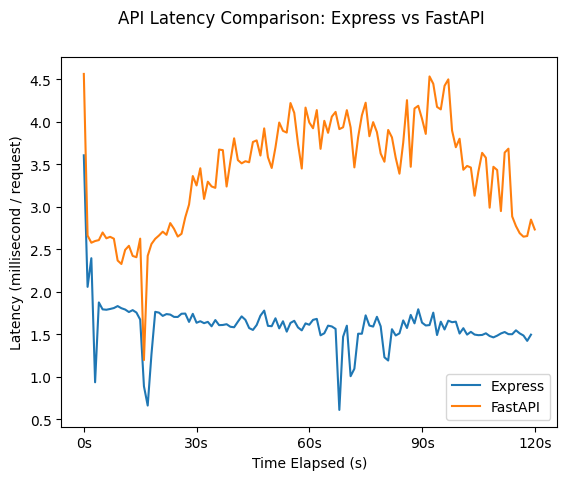

In [43]:
create_latency_comparison_timeseries_chart(express_http_duration_timeseries_df, fastapi_http_duration_timeseries_df, "API Latency Comparison: Express vs FastAPI")
create



In [ ]:
# Figure for load test
fig, ax = plt.subplots(1,1)
ax.plot(timeseries, express_http_duration_timeseries_df['metric_value'], label="Express")
ax.plot(fastapi_timeseries, fastapi_http_duration_timeseries_df['metric_value'], label="FastAPI")
ax.set_ylabel('Latency (millisecond / request)')
ax.set_xlabel('Time Elapsed (s)')
ax.set_xticks([0, 30, 60, 90, 120], labels=['0s', '30s', '60s', '90s', '120s'])
ax.legend()
fig.suptitle('API Latency Comparison: Express vs FastAPI')
fig.text(.001, 0, "Test increased users to 100 in 30 seconds, stayed at 100 users for 1 minute, then ramped down to 0 over 30 seconds")
fig.savefig('./load_test_comparison_timeseries.png')
plt.show()

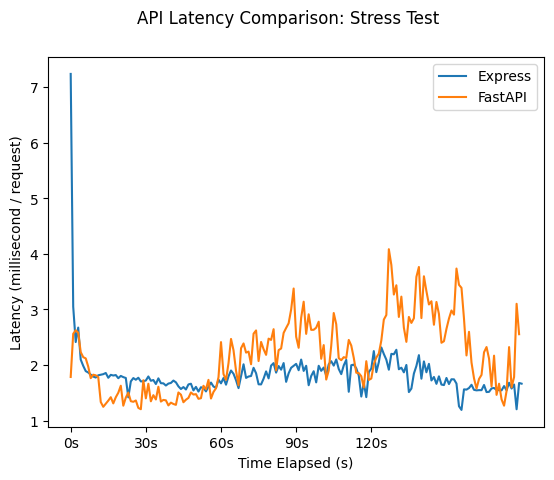

In [46]:
create_latency_comparison_timeseries_chart(express_stress_test_timeseries_df, fastapi_stress_test_timeseries_df, "API Latency Comparison: Stress Test", 'stress')